<a href="https://colab.research.google.com/github/mzohaibnasir/NeuralNotes/blob/main/06_convolutions_deepDiveIntoBasics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
#|default_exp conv


In [46]:
! git clone https://github.com/fastai/course22p2.git
!ls -a

fatal: destination path 'course22p2' already exists and is not an empty directory.
.  ..  .config	course22p2  data  sample_data


In [47]:
!ls /content/course22p2
!pip install -e /content/course22p2/.   # -e : editable   ; install current directory as python module


LICENSE      miniai	      nbs	 settings.ini  summaries
MANIFEST.in  miniai.egg-info  README.md  setup.py      xl
Obtaining file:///content/course22p2
  Preparing metadata (setup.py) ... done
  Attempting uninstall: miniai
    Found existing installation: miniai 0.0.1
    Uninstalling miniai-0.0.1:
      Successfully uninstalled miniai-0.0.1
  Running setup.py develop for miniai


# Convolutions

In [48]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
import pandas as pd,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor

from torch.utils.data import DataLoader
from typing import Mapping

In [49]:
#|export

import torch
from torch import nn

from torch.utils.data import default_collate
from typing import Mapping

mpl.rcParams['image.cmap'] = 'gray'

from miniai.training import *
from miniai.datasets import *

In [50]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/d15df08a69ed33ae16a2fff874f83b57a956172c/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True )
path_gz=path_data/'mnist.pkl.gz'
path_gz

Path('data/mnist.pkl.gz')

In [51]:
from urllib.request import urlretrieve

if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [52]:
!ls -l data

total 16656
-rw-r--r-- 1 root root 17051982 Jan 31 15:58 mnist.pkl.gz


In [53]:
with gzip.open(path_gz, 'rb') as f:   #read as binary as opposed to text
   ((x_train,y_train), (x_valid,y_valid), _) = pickle.load(f, encoding='latin-1') #destructuring
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In the context of an image, a feature is a visually distinctive attribute. For example, the number 7 is characterized by a horizontal edge near the top of the digit, and a top-right to bottom-left diagonal edge underneath that.

It turns out that finding the edges in an image is a very common task in computer vision, and is surprisingly straightforward. To do it, we use a convolution. A convolution requires nothing more than multiplication, and addition.

## Understanding the Convolution Equations
To explain the math behind convolutions, fast.ai student Matt Kleinsmith came up with the very clever idea of showing
https://medium.com/impactai/cnns-from-different-viewpoints-fab7f52d159c

In [54]:
# bias would be added per convolution(per kernel multiplication with pixels)

In [55]:
x_imgs = x_train.view(-1, 28, 28)
xv_imgs = x_valid.view(-1, 28, 28)

x_imgs.shape, xv_imgs.shape

(torch.Size([50000, 28, 28]), torch.Size([10000, 28, 28]))

In [56]:
mpl.rcParams['figure.dpi'] = 30

<Axes: >

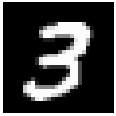

In [57]:
im3 = x_imgs[7]
show_image(im3)

<Axes: >

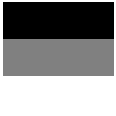

In [58]:
# lets create a kernel

# 3 TO HIGHLIGHT TOOP EDGES

top_edge = tensor([
    [-1,-1,-1],
    [0,0,0],
    [1,1,1]
]).float()

show_image(top_edge)

The filter will take any window of size 3*3 in our image, and if we name the pixel values like
*   a1 | a2 | a3
*   a4 | a5 | a6
*   a7 | a8 | a9


then output will be

* -a1 -a2 -a3 +0.a4 +0.a5 + 0.a6 + a7 + a8 + a9

In [59]:
im3.shape

torch.Size([28, 28])

In [60]:
df = pd.DataFrame(im3[:13,:23])
df.style.format(precision=2).set_properties(**{'font-size':'7pt'}).background_gradient('Greys')


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03


In [61]:
(im3[3:6,14:17] * top_edge).sum()

tensor(2.9727)

In [62]:
(im3[7:10,14:17] * top_edge).sum()

tensor(-2.9570)

In [63]:
def apply_kernel(row, col, kernel):
  return (im3[row-1:row+2,col-1:col+2] * kernel).sum()


In [64]:
apply_kernel(4,15,top_edge)


tensor(2.9727)

In [65]:
[[(i,j) for j in range(5)] for i in range(5)]

[[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)],
 [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 0), (3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]]

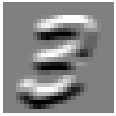

In [66]:
# TO HIGHLIGHT TOOP EDGES

top_edge = tensor([
    [-1,-1,-1],
    [0,0,0],
    [1,1,1]
]).float()


rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])
# print(top_edge3)
show_image(top_edge3);

In [67]:
left_edge = tensor([[-1,0,1],
                    [-1,0,1],
                    [-1,0,1]]).float()

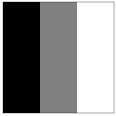

In [68]:
show_image(left_edge, noframe=False);


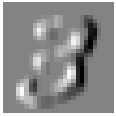

In [69]:
left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])
show_image(left_edge3);

# Convolutions in PyTorch

 convolutions like caffe using im2col


* img2col: flatteing kernels and image in such a way that it becomes matrix multiplication

In [70]:
import torch.nn.functional as F
import torch

In [71]:
inp = im3[None,None,:,:].float() # ppytorch expects (batch dimension, general dimsension, w,y)
inp_unf = F.unfold(inp, (3,3))[0]
inp.shape, inp_unf.shape

(torch.Size([1, 1, 28, 28]), torch.Size([9, 676]))

In [72]:
inp.view(28,-1).shape

torch.Size([28, 28])

In [73]:
#The unfold and fold are used to facilitate "sliding window" operations (like convolutions).

F.unfold(inp, (3,3)).shape

torch.Size([1, 9, 676])

In [74]:
left_edge.shape

torch.Size([3, 3])

In [75]:
w = left_edge.view(-1)
w.shape

torch.Size([9])

In [76]:
out_unf = w@inp_unf
out_unf.shape


torch.Size([676])

<Axes: >

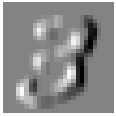

In [77]:
out = out_unf.view(26,26)
show_image(out)

In [78]:
%timeit -n 1 tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng]);


28.4 ms ± 3.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [79]:
%timeit -n 100 (w@F.unfold(inp, (3,3))[0]).view(26,26);


114 µs ± 22.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Conv2d

In [89]:
%timeit -n 100 F.conv2d(inp, left_edge[None,None])


26.8 µs ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [90]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()

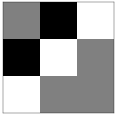

In [82]:
show_image(diag1_edge, noframe=False);


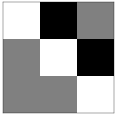

In [83]:
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()
show_image(diag2_edge, noframe=False);


## Conv on whole batch

In [84]:
xb = x_imgs[:16]
xb = xb[:,None]

In [85]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])[:,None]
edge_kernels.shape


torch.Size([4, 1, 3, 3])

In [86]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape    # 16 images, 4 kerenels, imgwith, imgheight

torch.Size([16, 4, 26, 26])

The output shape shows we gave 64 images in the mini-batch, 4 kernels, and 26×26 edge maps (we started with 28×28 images, but lost one pixel from each side as discussed earlier). We can see we get the same results as when we did this manually:

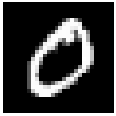

In [87]:
img0 = xb[1,0]
show_image(img0);

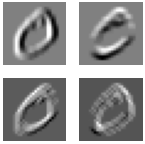

In [88]:
show_images([batch_features[1,i] for i in range(4)])


## Strides & padding  
odd size kernels are easier to deal with to make sure you end up with same thing you start with


stride 2 convs reduce grid by size 2

## Creating the CNN

In [88]:
n, m = x_train.shape
c = y_train.max()+1
nh = 50